Using device: cuda
Loaded VAE model successfully
Loaded Classifier model successfully


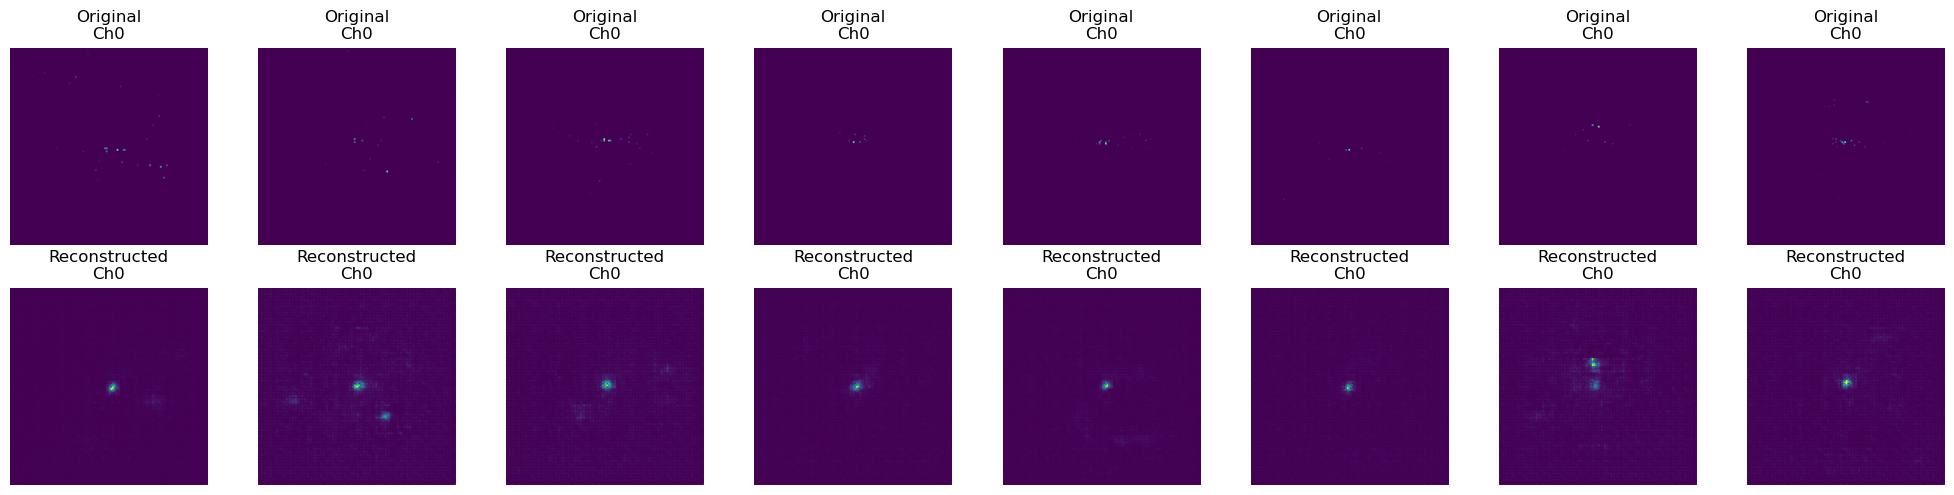

Test AUC with best classifier: 0.9024


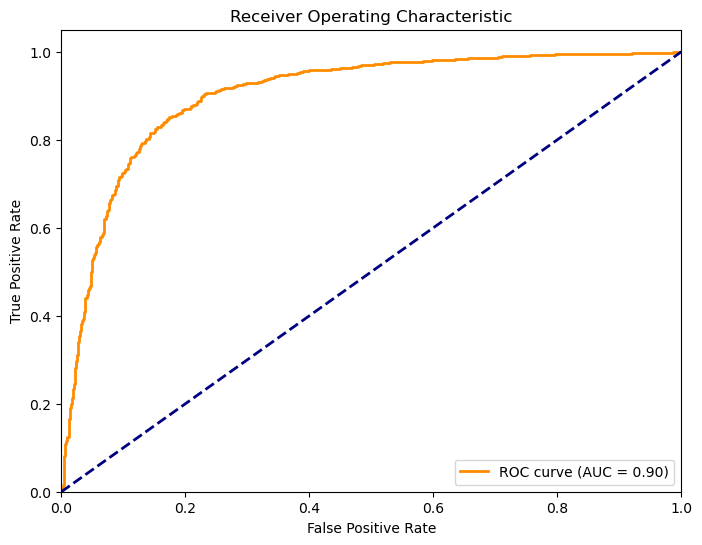

In [29]:
# Imports
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from models import UnlabelledJetDataset, LabelledJetDataset, VAE, Classifier

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load datasets
unlabelled_dataset = UnlabelledJetDataset('../Dataset_Specific_Unlabelled.h5')
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=256, shuffle=False, num_workers=16)

labelled_dataset = LabelledJetDataset('../Dataset_Specific_labelled.h5')
train_size = int(0.8 * len(labelled_dataset))
test_size = len(labelled_dataset) - train_size
_, test_labelled = random_split(labelled_dataset, [train_size, test_size])
labelled_test_loader = DataLoader(test_labelled, batch_size=64, shuffle=False, num_workers=4)

# Function to strip 'module.' prefix from state dictionary keys
def strip_module_prefix(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace('module.', '') if key.startswith('module.') else key
        new_state_dict[new_key] = value
    return new_state_dict

# Load best VAE for reconstructions
vae = VAE(latent_dim=128).to(device)
try:
    state_dict = torch.load('./res/best/best_vae.pth', map_location=device)
    vae.load_state_dict(strip_module_prefix(state_dict))
    print("Loaded VAE model successfully")
except FileNotFoundError:
    print("Error: './res/best_vae.pth' not found. Check the file path.")
except RuntimeError as e:
    print(f"Error loading VAE state_dict: {e}")
vae.eval()

# Load best Classifier for evaluation
vae_for_cls = VAE(latent_dim=128).to(device)
classifier = Classifier(vae_for_cls).to(device)
try:
    state_dict = torch.load('./res/best/best_classifier.pth', map_location=device)
    classifier.load_state_dict(strip_module_prefix(state_dict))
    print("Loaded Classifier model successfully")
except FileNotFoundError:
    print("Error: './res/best/best_classifier.pth' not found. Check the file path.")
except RuntimeError as e:
    print(f"Error loading Classifier state_dict: {e}")
classifier.eval()

# Visualization Functions
def visualize_reconstructions(model, dataloader, device, num_images=8, display_channel=0):
    model.eval()
    originals, reconstructions = [], []
    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, list):  # Handle labelled data
                batch = batch[0]
            batch = batch.to(device)
            recon, _, _ = model(batch)
            originals.append(batch.cpu())
            reconstructions.append(recon.cpu())
            if len(originals) * batch.size(0) >= num_images:
                break
    originals = torch.cat(originals)[:num_images]
    reconstructions = torch.cat(reconstructions)[:num_images]
    fig, axs = plt.subplots(2, num_images, figsize=(20, 5))
    for i in range(num_images):
        axs[0,i].imshow(originals[i][display_channel], cmap='viridis')
        axs[0,i].set_title(f'Original\nCh{display_channel}')
        axs[0,i].axis('off')
        axs[1,i].imshow(reconstructions[i][display_channel], cmap='viridis')
        axs[1,i].set_title(f'Reconstructed\nCh{display_channel}')
        axs[1,i].axis('off')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(all_labels, all_preds):
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Perform evaluations
# 1. Visualize reconstructions using the best VAE
visualize_reconstructions(vae, unlabelled_loader, device)

# 2. Compute predictions and plot ROC curve using the best Classifier
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in labelled_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = classifier(inputs)
        all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_auc = roc_auc_score(all_labels, all_preds)
print(f"Test AUC with best classifier: {test_auc:.4f}")
plot_roc_curve(all_labels, all_preds)